# Project Statistical Data Processing
Oscar Sjöstrand

Have you ever noticed that when you ask someone to rank something on a scale from 1 to 10, the answer is often 7? How good was the food? How good was that movie or book? How pretty is the view? If the food, book, movie, or view was neither particularly good nor bad, the answer often seems to be 7 out of 10. But why? Shouldn't the answer be 5 if the experience was average?

This phenomenon might stem from cultural norms where "average" is perceived as negative, and the person avoids being rude. Alternatively, it could reflect that most experiences exceed expectations (assuming an expected score of 5). But what happens when we rely on experts? Does the distribution of scores align more closely with what we might expect?

In this paper, we will study how audience and movie critics' opinions differ when scoring streamable movies. We will use data from the website Rotten Tomatoes, where each movie receives aggregated scores from both critics and audiences. Each score is categorized as either 'fresh' or 'rotten' and represented as a percentage. An aggregated score of 50% reflects an equal number of fresh and rotten votes. Movies with a score of 60% or greater are considered 'fresh'; otherwise, they are labeled as 'rotten.' Critics are members of writing guilds or film critics' associations, while the audience scores come from registered Rotten Tomatoes users.

It is important to note that these scores are dynamic, meaning that critics and audience members can rate older movies, altering their scores over time. However, we can assume that most scores are given while the movie is still relatively new. This scoring system may eliminate the biases inherent in asking someone to rank something from 1 to 10, but it could also introduce positive skewness. For instance, when voting 'fresh' or 'rotten' for an average movie, voters might lean towards 'fresh' because even average movies are often enjoyable.

To explore this, we aim to answer the following questions:

* Do movie critics and audiences differ in their ratings of movies on average?
* What can we observe about the distribution of scores?
* How do the distributions of critics' and audiences' scores differ?
* Are there genres with consistently better or worse ratings?

To address these questions, we will scrape data from Rotten Tomatoes, analyze it, and visualize the findings in relevant figures.

### Web Scrapning
To scrape the website, we use the libraries: `requests`, `bs4`, and `pandas`. The library request to read the url of the website we are interested in and extract the information, BeautifulSoup to compile the html and pandas to create a dataframe which we will use to study the data. 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def extract_page(url, index):
    """Extracts movie data from a single page."""
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')

    # List to store movie data
    data_list = []

    # Find all movies on the page
    movie_list = soup.find_all('a', {'data-qa': 'discovery-media-list-item-caption'})
    
    # To avoid duplicates
    if index == 0:
        movie_list = movie_list
    else:
        movie_list = movie_list[index:]
        
    # Extract data for each movie
    for movie in movie_list:
        #try:
            critic_score = movie.find('rt-text', {'slot': 'criticsScore'}).get_text(strip=True)
            audience_score = movie.find('rt-text', {'slot': 'audienceScore'}).get_text(strip=True)
            movie_name = movie.find('span', {'data-qa': 'discovery-media-list-item-title'}).get_text(strip=True)
            release_date = movie.find('span', {'data-qa': 'discovery-media-list-item-start-date'}).get_text(strip=True)

            # Add movie data as a dictionary
            data_list.append({
                'Title': movie_name,
                'Critic Score': critic_score,
                'Audience Score': audience_score,
                'Release Date': release_date
            })
        #except AttributeError:
            # Skip movies with missing data
            #continue

    return data_list

"""
Let's loop over the categories and compile the data into a dataframe.
"""

# Base URL
base_url = 'https://www.rottentomatoes.com/browse/movies_at_home/'

# List to store data across all pages
all_data = []

genres = ['action', 'adventure', 'animation', 'anime', 'biography', 'comedy', 'crime', 
          'documentary', 'drama', 'entertainment', 'faith_and_spirituality', 'fantasy', 
          'game_show', 'health_and_wellness', 'history', 'holiday', 'horror', 'house_and_garden', 
          'kids_and_family', 'lgbtq', 'music', 'musical', 'mystery_and_thriller', 'nature', 'news', 
          'reality', 'romance', 'sci_fi', 'short', 'soap', 'special_interest', 'sports', 'stand_up', 
          'talk_show', 'travel', 'variety', 'war', 'western']

for genre in genres:
    genre_url = base_url + f'genres:{genre}'
    
    page_num = 1
    index = 0
    while True:
        if page_num == 1:
            current_url = genre_url
        else:
            current_url = genre_url + f'?page={page_num}'

        # Extract data from the current page
        page_data = extract_page(current_url, index)

        # If no data is returned, we've reached the last page
        if not page_data:
            break
        
        # Add genres
        for movie in page_data:
            movie['Genre'] = genre
            
        # Append the data
        all_data.extend(page_data)
        
        # Make sure there are no duplicates
        index = len(all_data)

        # Increment page number
        page_num += 1

df = pd.DataFrame(all_data)
df

,Title,Critic Score,Audience Score,Release Date,Genre
0,Survive,,,"Streaming Jan 10, 2025",action
1,Laws of Man,,,"Streaming Jan 10, 2025",action
2,Carry-On,88%,52%,"Streaming Dec 13, 2024",action
3,Gladiator II,71%,82%,"Streaming Dec 24, 2024",action
4,In the Heart of the Sea,42%,54%,"Streaming Aug 10, 2016",action
...,...,...,...,...,...
686,The Ballad of Buster Scruggs,89%,78%,"Streaming Nov 16, 2018",western
687,The Ridiculous 6,0%,36%,"Streaming Apr 3, 2017",western
688,Butcher's Crossing,72%,50%,"Streaming Nov 7, 2023",western
689,Place of Bones,77%,,"Streaming Aug 23, 2024",western


### Data Cleaning and Visualization

After creating our DataFrame, we noticed some missing values, primarily where audience scores are unavailable. To address this issue, we remove these entries, as the objective of this study is to compare audience and critic scores. Additionally, we identified a category containing only a single movie, which we also excluded to ensure meaningful comparisons across categories.

In [ ]:
import numpy as np
df.replace('', np.nan, inplace =True)
df.dropna(inplace = True)
df = df[df['Genre'] != 'special_interest']

df['Critic Score'] = df['Critic Score'].str.rstrip('%').astype(float)/100
df['Audience Score'] = df['Audience Score'].str.rstrip('%').astype(float)/100
df['Release Date'] = df['Release Date'].str.extract(r'(\d{4})').astype(int)

We now have our clean data. Now, let us visualize the data to answer the questions stated in the begining. First, we want to visualize the distributions of audience and critics score. 

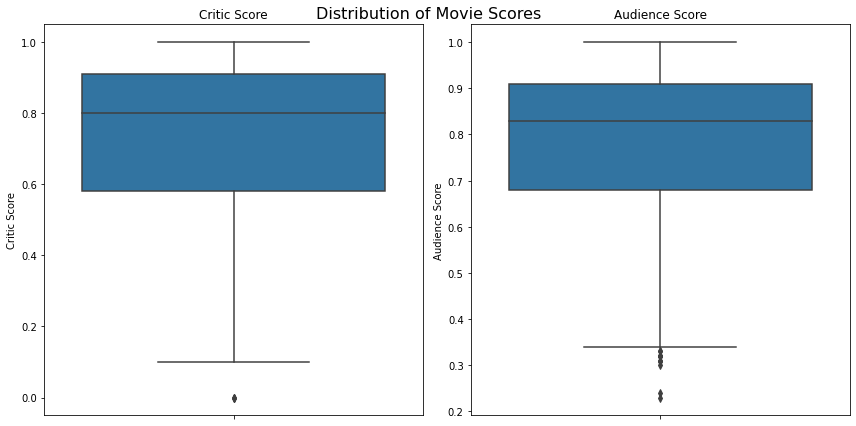

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Adjust figure size as needed

# Plot boxplots on respective axes
sns.boxplot(data=df, y='Critic Score', ax=axs[0])
sns.boxplot(data=df, y='Audience Score', ax=axs[1])

# Add titles to each subplot
axs[0].set_title('Critic Score')
axs[1].set_title('Audience Score')

# Show the plot
plt.tight_layout()
plt.suptitle('Distribution of Movie Scores', fontsize= 20)
plt.show()

critic_median = df['Critic Score'].median()
audience_median = df['Audience Score'].median()
critic_mean = df['Critic Score'].mean()
audience_mean = df['Audience Score'].mean()

We observe that the audience median score is slightly higher than the critics' median score, specifically 83% compared to 80%. Similarly, the mean scores show that the audience average is 78%, while the critics' average is 73%. This indicates that, on average, the audience rates the same movie 5% higher than the critics. Furthermore, visual inspection of the data reveals that audience scores tend to be consistently higher than critics' scores.

One might expect the mean and median to be close to 50%. Why 50%? We know that data often approximates a normal distribution. For an average movie, we would assume an equal number of "fresh" and "rotten" votes, resulting in a score of 50%. However, both the median and mean scores for critics and audience are significantly higher than 50%. This suggests that the data is positively skewed toward higher scores.

This positive skew could indicate that movies generally exceed the expectations of both critics and the audience. If the quality of movies were constant, we would expect the scores to eventually stabilize around 50%. However, testing this hypothesis is challenging. If movie quality improves at the same rate as audience and critics' expectations, the scores would remain constant. Conversely, if expectations increase while movie quality remains constant, the scores would decline over time and stabilize around 50%. To explore this, we can examine the trend in scores over time by plotting them.

<ipython-input-19-ea0ef981a51e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
<ipython-input-19-ea0ef981a51e>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


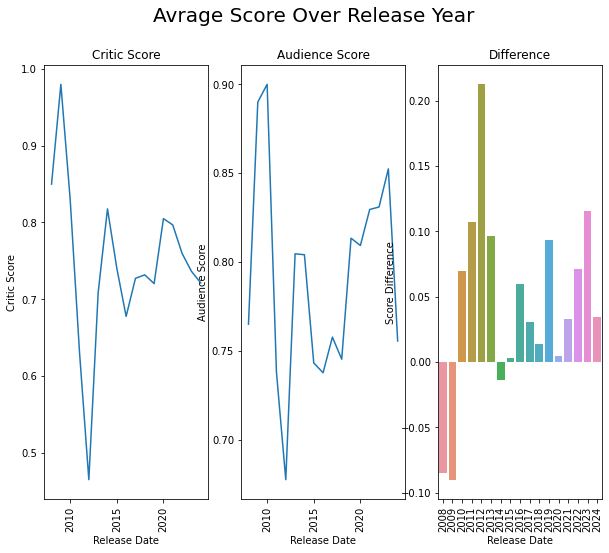

In [19]:
release_scores = df.groupby('Release Date').agg({
    'Critic Score': 'mean',
    'Audience Score': 'mean'
}).reset_index()

release_scores['Score Difference'] = release_scores['Audience Score'] - release_scores['Critic Score']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

sns.lineplot(data = df, 
            x = 'Release Date', 
            y = 'Critic Score', 
            ax=axs[0],
            ci = None)                        

sns.lineplot(x = 'Release Date',
           y = 'Audience Score',
           data = df,
           ax=axs[1],
           ci = None)
                     
sns.barplot(data = release_scores,
           x = 'Release Date',
           y = 'Score Difference',
           ax = axs[2])

axs[0].set_title('Critic Score')
axs[1].set_title('Audience Score')  
axs[2].set_title('Difference')

# Rotate x-axis labels for both subplots
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)

plt.suptitle('Average Score Over Release Year', fontsize=20)
plt.show()

We can not see a clear trend if movies get better or worse depending on release year. For years prior to 2013 (with the exception of 2011), the sample size is four or fewer. If we exclude these years then we can detect a slight upwards trend. If we assume a positive trend, this would, based on our earlier reasoning, mean that either the expectation is decreasing or the quality of the movies are increasing. If we assume no clear trend then the changes of expectation and quality would cancel each other out. 

We can not draw any more conclusions of the difference between the critics and audience score. We will explore how to conduct further research in the conclusion. 

Now, let us study the scores over the genres. `seaborn` plots by default the mean of the scores and a bar showing the standard deviation.

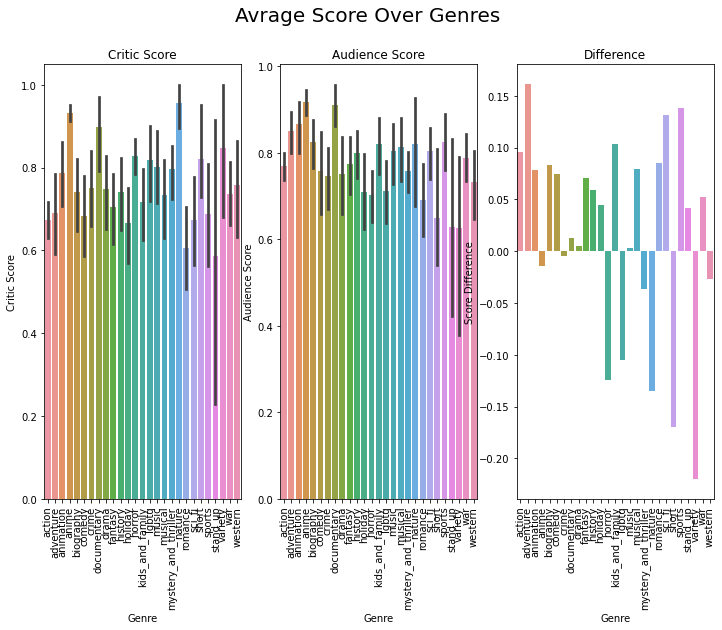

In [8]:
# Group by genre and calculate the mean of each score type
genre_scores = df.groupby('Genre').agg({
    'Critic Score': 'mean',
    'Audience Score': 'mean'
}).reset_index()

genre_scores['Score Difference'] = genre_scores['Audience Score'] - genre_scores['Critic Score']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

sns.barplot(data = df, 
            x = 'Genre', 
            y = 'Critic Score', 
            ax=axs[0])                        

sns.barplot(x = 'Genre',
           y = 'Audience Score',
           data = df,
           ax=axs[1])
                     
sns.barplot(data = genre_scores,
           x = 'Genre',
           y = 'Score Difference',
           ax = axs[2])

axs[0].set_title('Critic Score')
axs[1].set_title('Audience Score')  
axs[2].set_title('Difference')

# Rotate x-axis labels for both subplots
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)

plt.suptitle('Avrage Score Over Genres', fontsize=20)
plt.show()

Let us begin by examining the critics' scores. The three highest-rated genres, according to critics, are nature, anime, and drama. For audience scores, the three highest-rated genres are anime, documentaries, and animation.

The largest differences in scores are observed in the genres of variety, sports, and short films. Critics rate variety and short films higher, while the audience rates sports films more favorably.

### Conclusion

We have explored the data scraped from the Rotten Tomatoes website, focusing on the distribution of scores and the differences between critics' and audience scores. To analyze these differences, we examined the scores over time and across different categories.

We found that the distribution of scores is positively skewed, with the mean and median being 80% and 73% for critics, and 82% and 78% for audience scores, respectively. This skewness could be explained by a mismatch between expectations and the actual quality of movies. If expectations were perfectly accurate, we would expect a mean and median closer to 50%. To test if the scores would aggregate aroud a normal distribution we could introduce a new score for the critics and audience members to choose, the "normal movie" score. If fresh gives a 1 and a rotten gives a -1, normal movie would give a 0. The site could also ask the "voters" not to score the movie if they thougth it was average but it would probably be harder to control. This could help Rotten Tomatoes give more accurate recommendations.   

Additionally, we observed that the audience tends to rate movies about five percentage points higher than critics on average. When examining genres, the audience favors anime, documentaries, and animation, while critics prefer nature, anime, and drama. Interestingly, both critics and the audience consistently rate anime highly, making it a reliable choice for viewers seeking quality entertainment.